Install DGL

Import the necessary pacakges

In [2]:
import dgl
import numpy as np
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp

**Q2**

import the karate dataset

In [2]:
import dgl.data

dataset = dgl.data.KarateClubDataset()
g = dataset[0]


Preprocess the dataset

In [3]:
# Split edge set for training and testing
u, v = g.edges()

# Find all negative edges 
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

# split the postive and negative graphes
pos_g = dgl.graph(
    (u, v), num_nodes=g.number_of_nodes()
)
neg_g = dgl.graph(
    (neg_u, neg_v), num_nodes=g.number_of_nodes()
)

Initialize the node embedding

In [4]:
node_embed = nn.Embedding(g.number_of_nodes(), 2)  
inputs = node_embed.weight                         
nn.init.xavier_uniform_(inputs)

Parameter containing:
tensor([[ 0.2716, -0.3729],
        [-0.3491, -0.2162],
        [ 0.0663, -0.3428],
        [-0.3503,  0.2174],
        [ 0.3372, -0.1619],
        [ 0.3091, -0.3253],
        [ 0.2180, -0.1143],
        [-0.1196, -0.0931],
        [-0.2972,  0.2970],
        [-0.1991, -0.0413],
        [ 0.1372, -0.2889],
        [-0.1528,  0.0101],
        [ 0.1356, -0.0471],
        [-0.2765, -0.1426],
        [-0.1972,  0.1679],
        [-0.4075,  0.2058],
        [-0.3135,  0.2592],
        [-0.3657, -0.1896],
        [ 0.3312, -0.1309],
        [ 0.2869,  0.0245],
        [ 0.0534, -0.0735],
        [ 0.1260,  0.1077],
        [ 0.1255, -0.1624],
        [ 0.3733,  0.3012],
        [ 0.0411, -0.0033],
        [ 0.3178,  0.3677],
        [-0.2656, -0.3366],
        [-0.1032, -0.3848],
        [ 0.1351,  0.2381],
        [ 0.2377, -0.1008],
        [-0.1213, -0.0153],
        [ 0.1659, -0.0566],
        [ 0.2280,  0.0203],
        [-0.3185,  0.3572]], requires_grad=True)

Build the model based on  GraphSAGE.





In [5]:
from dgl.nn import SAGEConv

class Model(nn.Module):
    def __init__(self, input_feats, h_feats):
        super(Model, self).__init__()
        '''please build the two GraphSAGE layers.'''
        self.gnn1 = SAGEConv(input_feats, h_feats, 'mean')
        self.gnn2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        hidden1 = self.gnn1(g, in_feat)
        hidden1_ar = F.relu(hidden1)
        h = self.gnn2(g, hidden1_ar)
        return h

Define the adjacency-based similarity loss

In [6]:
import dgl.function as fn


class Score(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

model = Model(2,2)
score = Score() 


def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return torch.mean((scores-labels)**2)

Train the network

In [7]:
import itertools
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), node_embed.parameters()), lr=0.01)


for e in range(100):
      # forward
      h = model(g,inputs)
      pos_score = score(pos_g,h) 
      neg_score = score(neg_g,h) 
      '''please add the loss function into the training scheme'''
      loss = compute_loss(pos_score, neg_score)
      # backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print("In epoch {}, loss: {}".format(e, loss))

/Users/apple/opt/anaconda3/envs/COMP4641/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, loss: 0.28324785828590393
In epoch 1, loss: 0.25062090158462524
In epoch 2, loss: 0.22385743260383606
In epoch 3, loss: 0.20291076600551605
In epoch 4, loss: 0.18650899827480316
In epoch 5, loss: 0.17334531247615814
In epoch 6, loss: 0.1631612479686737
In epoch 7, loss: 0.1548176258802414
In epoch 8, loss: 0.1481575071811676
In epoch 9, loss: 0.14267423748970032
In epoch 10, loss: 0.1382024884223938
In epoch 11, loss: 0.13519230484962463
In epoch 12, loss: 0.13264165818691254
In epoch 13, loss: 0.1304752379655838
In epoch 14, loss: 0.12862148880958557
In epoch 15, loss: 0.1270371824502945
In epoch 16, loss: 0.12568555772304535
In epoch 17, loss: 0.12453462183475494
In epoch 18, loss: 0.1235567107796669
In epoch 19, loss: 0.12271176278591156
In epoch 20, loss: 0.12198255211114883
In epoch 21, loss: 0.12136872112751007
In epoch 22, loss: 0.12085410952568054
In epoch 23, loss: 0.12042465060949326
In epoch 24, loss: 0.1200680360198021
In epoch 25, loss: 0.11977358162403107
In e

Draw the embedding

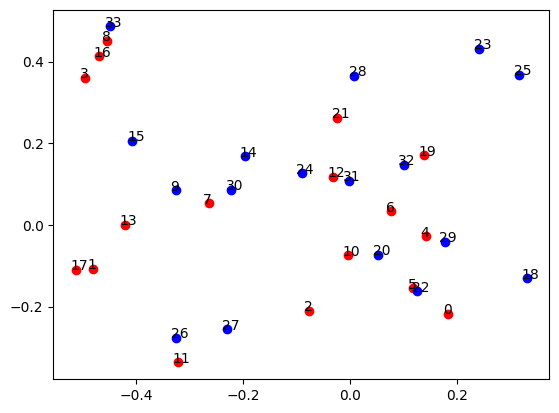

In [8]:
import matplotlib.pyplot as plt

labels = g.ndata['label'] #obtain the labels

for ind,node in enumerate(g.nodes()):  
    if labels[ind] == 0:
        color = 'red'
    else:
        color = 'blue'
      
    '''please draw the embedding using plt.scatter()'''
    plt.scatter(node_embed.weight.detach().numpy()[ind,0], node_embed.weight.detach().numpy()[ind,1], c=color)

    plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

Cluster using kmeans.

/Users/apple/opt/anaconda3/envs/COMP4641/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


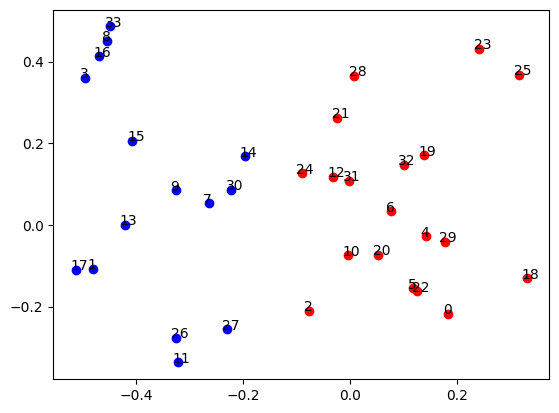

In [9]:
#Import Kmeans,networkx and matplotlib
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt

'''please conduct the clustering via sklearn.cluster.Kmeans() function'''
kmeans = KMeans(n_clusters=2, random_state=0).fit(node_embed.weight.detach().numpy())

# Get the predicted cluster labels
pred_labels = kmeans.labels_

#Visualize the embeddings
for ind,node in enumerate(g.nodes()):
  if pred_labels[ind] == 0:
    color = 'red'
  else:
    color = 'blue'
  '''please draw the embedding using plt.scatter()'''
  plt.scatter(node_embed.weight.detach().numpy()[ind,0], node_embed.weight.detach().numpy()[ind,1], c=color)
  
  plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

Repeat the 3 steps above, but with 3 GNN layers and 2-hop similarity function.

You can modify the codes above.


Regenerate the training data that can be combined with the 2-hop similarity function. 

In [10]:
#obtain the two hop neighbor subgraph
sg,_ = dgl.khop_in_subgraph(g, 0, k=2)


node_id_map = {}
for i,org_id in enumerate(sg.ndata[dgl.NID]):
    node_id_map[i] = int(org_id.numpy())
    

###obtain the edges in original graph, as well as the edges in two hop neighbor subgraph.
u, v = g.edges()
u_s, v_s = sg.edges()

# Map the nodes with its original ID.
for j,uu in enumerate(u_s):
    u_s[j] = torch.tensor(node_id_map[int(uu.numpy())])

for j,vv in enumerate(v_s):
    v_s[j] = torch.tensor(node_id_map[int(vv.numpy())])


# Find all negative edges 
#(positive edge means the two nodes are connected in the two hop neighbors subgraph) 
adj = sp.coo_matrix((np.ones(len(u_s)), (u_s.numpy(), v_s.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

### build the positive and negative graph
pos_g = dgl.graph(
    (u_s, v_s), num_nodes=g.number_of_nodes()
)
neg_g = dgl.graph(
    (neg_u, neg_v), num_nodes=g.number_of_nodes()
)

Initialize the node embedding

In [11]:
node_embed = nn.Embedding(g.number_of_nodes(), 2)  
inputs = node_embed.weight
nn.init.xavier_uniform_(inputs)

Parameter containing:
tensor([[ 0.0245, -0.3648],
        [ 0.1539, -0.1705],
        [-0.0365,  0.2935],
        [-0.0126, -0.1936],
        [-0.1757,  0.3919],
        [ 0.1003,  0.0607],
        [ 0.2383,  0.1285],
        [ 0.3456, -0.2160],
        [-0.3881, -0.2707],
        [-0.2210, -0.0187],
        [-0.3882,  0.3028],
        [ 0.3234, -0.3707],
        [ 0.4046, -0.0414],
        [ 0.2387,  0.1315],
        [ 0.2309, -0.2197],
        [ 0.1458, -0.0491],
        [ 0.0749, -0.2116],
        [ 0.1894,  0.0385],
        [-0.2451, -0.0521],
        [ 0.0223, -0.1331],
        [-0.1205,  0.3471],
        [-0.3013,  0.2086],
        [ 0.0960, -0.2863],
        [ 0.0035,  0.2105],
        [-0.2463, -0.0624],
        [-0.2769, -0.0707],
        [-0.0329,  0.1247],
        [ 0.2321,  0.2548],
        [ 0.0784, -0.1488],
        [ 0.2199, -0.3713],
        [-0.2365, -0.1743],
        [ 0.2091,  0.2061],
        [ 0.3925, -0.0381],
        [ 0.0294,  0.0607]], requires_grad=True)

Build the model based on GraphSAGE.

In [12]:
from dgl.nn import SAGEConv

class Model(nn.Module):
    def __init__(self, input_feats, h_feats):
        super(Model, self).__init__()
        '''please build the three GraphSAGE layers.'''
        self.gnn1 = SAGEConv(input_feats, h_feats, 'mean')
        self.gnn2 = SAGEConv(h_feats, h_feats, 'mean')
        self.gnn3 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        hidden1 = self.gnn1(g, in_feat)
        hidden1_ar = F.relu(hidden1)
        h = self.gnn2(g, hidden1_ar)
        return h

Define the two-hop similarity loss.

In [13]:
class TwoHopScore(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute two-hop neighbor features using message passing
            g.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h2'))
            g.update_all(fn.copy_u('h2', 'm'), fn.sum('m', 'h2'))
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h2' and destination node feature 'h2'.
            g.apply_edges(fn.u_dot_v('h2', 'h2', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

model = Model(2, 2)
score = TwoHopScore()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return torch.mean((scores - labels) ** 2)

Train the network

In [14]:
import itertools
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), node_embed.parameters()), lr=0.01)


for e in range(100):
      # forward
      h = model(g,inputs)
      pos_score = score(pos_g,h) 
      neg_score = score(neg_g,h) 
      '''please add the loss function into the training scheme'''
      loss = compute_loss(pos_score, neg_score)
      # backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print("In epoch {}, loss: {}".format(e, loss))

/Users/apple/opt/anaconda3/envs/COMP4641/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, loss: 20726786048.0
In epoch 1, loss: 11400732672.0
In epoch 2, loss: 5858877440.0
In epoch 3, loss: 2803979264.0
In epoch 4, loss: 1242579840.0
In epoch 5, loss: 502601472.0
In epoch 6, loss: 179092288.0
In epoch 7, loss: 53117600.0
In epoch 8, loss: 11780760.0
In epoch 9, loss: 1541017.125
In epoch 10, loss: 67549.4453125
In epoch 11, loss: 28753.208984375
In epoch 12, loss: 499041.03125
In epoch 13, loss: 2871478.75
In epoch 14, loss: 8973925.0
In epoch 15, loss: 20232414.0
In epoch 16, loss: 37323276.0
In epoch 17, loss: 60059568.0
In epoch 18, loss: 87412296.0
In epoch 19, loss: 117638344.0
In epoch 20, loss: 148504400.0
In epoch 21, loss: 177581744.0
In epoch 22, loss: 202570608.0
In epoch 23, loss: 221597072.0
In epoch 24, loss: 233441184.0
In epoch 25, loss: 237646096.0
In epoch 26, loss: 234507440.0
In epoch 27, loss: 226170432.0
In epoch 28, loss: 214603904.0
In epoch 29, loss: 199165776.0
In epoch 30, loss: 181191200.0
In epoch 31, loss: 161930896.0
In epoch 32, 


Draw the embedding

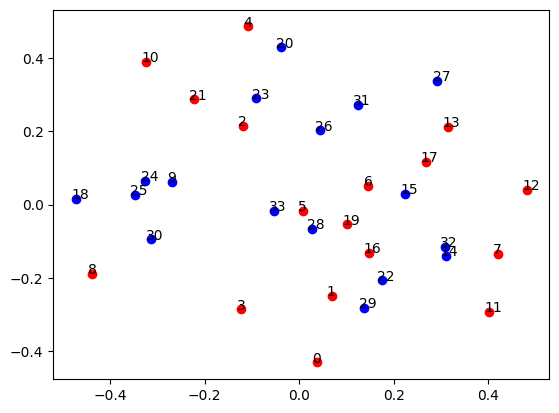

In [15]:
labels = g.ndata['label'] #obtain the labels

for ind,node in enumerate(g.nodes()):  
    if labels[ind] == 0:
        color = 'red'
    else:
        color = 'blue'
      
    '''please draw the embedding using plt.scatter()'''
    plt.scatter(node_embed.weight.detach().numpy()[ind,0], node_embed.weight.detach().numpy()[ind,1], c=color)

    plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

Cluster using kmeans.

/Users/apple/opt/anaconda3/envs/COMP4641/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


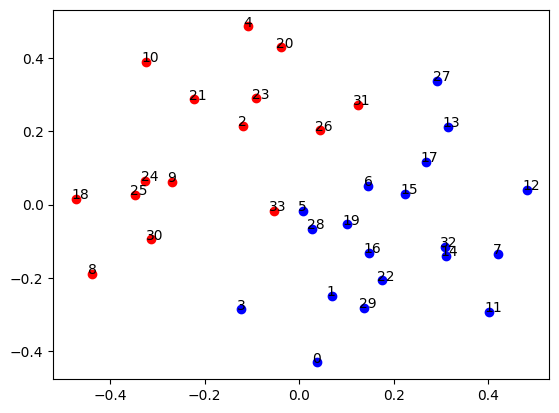

In [16]:
'''please conduct the clustering via sklearn.cluster.Kmeans() function'''
kmeans = KMeans(n_clusters=2, random_state=0).fit(node_embed.weight.detach().numpy())

# Get the predicted cluster labels
pred_labels = kmeans.labels_

#Visualize the embeddings
for ind,node in enumerate(g.nodes()):
  if pred_labels[ind] == 0:
    color = 'red'
  else:
    color = 'blue'
  '''please draw the embedding using plt.scatter()'''
  plt.scatter(node_embed.weight.detach().numpy()[ind,0], node_embed.weight.detach().numpy()[ind,1], c=color)
  
  plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

In [17]:
cock

NameError: name 'cock' is not defined

**Q3**
Node Classfication


import the Cora dataset

In [1]:
import dgl.data
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Build the model based on  GraphSAGE.


In [3]:
'''please build the model'''
from dgl.nn import SAGEConv

class Model(nn.Module):
    def __init__(self, input_feats, h_feats):
        super(Model, self).__init__()
        '''please build GraphSAGE layer '''
        self.gnn1 = SAGEConv(input_feats, h_feats, "mean")
        self.gnn2 = SAGEConv(h_feats, h_feats, "mean")

    def forward(self, g, in_feat):
        hidden1 = self.gnn1(g, in_feat)
        hidden1_ar = F.relu(hidden1)
        h = self.gnn2(g, hidden1_ar)
        return h

Define the linear classifier

In [4]:
'''please build the classifier'''
class Classifier(nn.Module):
    def __init__(self, h_feat, num_classes):
        super(Classifier, self).__init__()
        '''please build the linear classfier '''
        self.fc1 = nn.Linear(h_feat, num_classes)

    def forward(self, in_feat):
        h = self.fc1(in_feat)
        return h

Train the NN.

In [5]:
import itertools

h_feat = 128
num_classes = 10
input_feats = 1433
h_feats = 128

'''please complete the functions for the  model'''
classifier = Classifier(h_feat, num_classes)
model = Model(input_feats, h_feats)
optimizer = torch.optim.Adam(
itertools.chain(model.parameters(), classifier.parameters()), lr=0.01)

features = g.ndata["feat"]
labels = g.ndata["label"]
train_mask = g.ndata["train_mask"]
val_mask = g.ndata["val_mask"]
test_mask = g.ndata["test_mask"]

best_val_acc = 0.0
best_test_acc = 0.0

for e in range(100):
    '''please fill in the missing "Forward" and "Compute loss" in training process'''
    # Forward
    hidden = model(g, features)
    logits = classifier(hidden)

    # Compute prediction
    pred = logits.argmax(1)

    # Compute loss
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute accuracy on training/validation/test
    train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
    val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
    test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

    # Save the best validation accuracy and the corresponding test accuracy.
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc





    # Compute accuracy on training/validation/test
    train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
    val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
    test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

    print(
            "In epoch {}, loss: {:.3f}, val acc: {:.3f}, test acc: {:.3f}".format(
                e, loss, val_acc, test_acc
            )
        )

/Users/apple/opt/anaconda3/envs/COMP4641/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, loss: 2.310, val acc: 0.000, test acc: 0.000
In epoch 1, loss: 2.180, val acc: 0.382, test acc: 0.374
In epoch 2, loss: 2.015, val acc: 0.516, test acc: 0.508
In epoch 3, loss: 1.797, val acc: 0.728, test acc: 0.717
In epoch 4, loss: 1.553, val acc: 0.688, test acc: 0.663
In epoch 5, loss: 1.275, val acc: 0.716, test acc: 0.705
In epoch 6, loss: 0.947, val acc: 0.770, test acc: 0.776
In epoch 7, loss: 0.608, val acc: 0.782, test acc: 0.781
In epoch 8, loss: 0.327, val acc: 0.770, test acc: 0.770
In epoch 9, loss: 0.148, val acc: 0.764, test acc: 0.777
In epoch 10, loss: 0.059, val acc: 0.772, test acc: 0.787
In epoch 11, loss: 0.022, val acc: 0.770, test acc: 0.787
In epoch 12, loss: 0.007, val acc: 0.768, test acc: 0.784
In epoch 13, loss: 0.002, val acc: 0.768, test acc: 0.783
In epoch 14, loss: 0.001, val acc: 0.764, test acc: 0.783
In epoch 15, loss: 0.000, val acc: 0.764, test acc: 0.782
In epoch 16, loss: 0.000, val acc: 0.762, test acc: 0.783
In epoch 17, loss: 0.000